<a href="https://colab.research.google.com/github/rxchit/anime-faces-AI/blob/main/Generate_Anime_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating Stylized faces using StyleGAN**

In [1]:
#@title ##Google Drive Integration
#@markdown To connect Google Drive, set `root_path` to the relative drive folder path you want outputs to be saved to if you already made a directory, then execute this cell. Leaving the field blank or just not running this will have outputs save to the runtime temp storage.
import os
root_path = "AI-anime" #@param {type: "string"}
abs_root_path = "/content"
if len(root_path) > 0:
    abs_root_path = abs_root_path + "/drive/MyDrive/" + root_path

from google.colab import drive
drive.mount('/content/drive')

def ensureProperRootPath():
    if len(abs_root_path) > 0:
        os.chdir(abs_root_path) # Changes directory to absolute root path
        print("Root path check: ")
        !pwd

ensureProperRootPath()

Mounted at /content/drive
Root path check: 
/content/drive/MyDrive/AI-anime


In [2]:
#@title ##Setup, Installing Libraries
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__
!pip install tqdm
print("Cloning StyleGAN2")
!git clone https://github.com/NVlabs/stylegan2.git

print("changing directory")
%cd /content/drive/MyDrive/AI-anime/stylegan2

TensorFlow 1.x selected.
Cloning StyleGAN2
fatal: destination path 'stylegan2' already exists and is not an empty directory.
changing directory
/content/drive/MyDrive/AI-anime/stylegan2


In [26]:
#@title ##Selection of models 
#@markdown This cell assumes that the pre-trained models are placed in your root of Google drive ie: `*/content/drive/MyDrive*` 
#@markdown > The drive is mount at this address in the above cell, These models are available here https://drive.google.com/drive/folders/102PMZCwf-XHZQrpQdPpRnwEqKBeUBRk2?usp=sharing
import pretrained_networks

model_choice = 'female' #@param ["female","male","snapshot-v2"]

if (model_choice == 'male'):
    network_pkl = '/content/drive/MyDrive/male-snapshot-018528.pkl'

elif (model_choice == 'female'):
    network_pkl = '/content/drive/MyDrive/female-snapshot-018528.pkl'

else:
    network_pkl = '/content/drive/MyDrive/v2-network-snapshot-018556.pkl'

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [27]:
# @title ##Loading libraries and definitions
Gs.vars["dlatent_avg"].value().eval()     # Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
    w,h = images[0].size
    w = int(w*scale)
    h = int(h*scale)
    height = rows*h
    cols = ceil(len(images) / rows)
    width = cols*w
    canvas = PIL.Image.new('RGBA', (width,height), 'white')
    for i,img in enumerate(images):
        img = img.resize((w,h), PIL.Image.ANTIALIAS)
        canvas.paste(img, (w*(i % cols), h*(i // cols))) 
    return canvas

def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps) 
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out

def saveImages(size = 10, folder = ""):
    seeds = np.random.randint(10000000, size=size)
    print(seeds)

    psi = .7

    zs = generate_zs_from_seeds(seeds)
    imgs = generate_images(zs, psi)
    for index, img in enumerate(imgs):
        img.save(folder + "face_" + str(index+1) + ".png", format="png")


[7696400 5573755 9939245 4399885   46827 5671967 5953201 7631704 9073562]


9it [00:01,  6.93it/s]


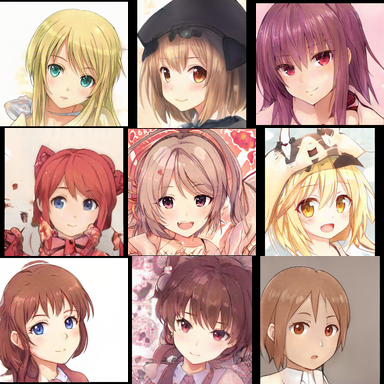

In [47]:
#@title Generating Output
#@markdown Generates a 3x3 grid

# generate some random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

createImageGrid(imgs, rows=3)


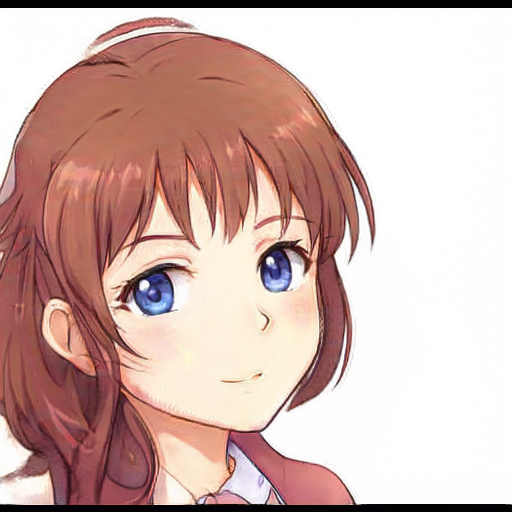

In [49]:
#@markdown ####OneImage
it = 7 #@param {type:"slider", min:1, max:9 , step:1}
it -=1 
imgs[it]

7it [00:00,  7.47it/s]


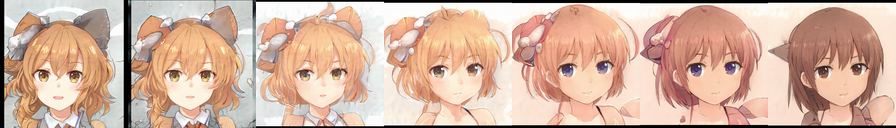

In [45]:
#@title Generating Interpolation
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=1)

In [46]:
#@title Saving images to drive
#@markdown Saves random generated faces to users Google drive
noOfImgs = 10 #@param {type:"integer"}
saveImages(noOfImgs, folder = "/content/drive/MyDrive/AI-anime/")



[3686270   30414 9177439 9963847 8779265  615941 5015124  770677 4486134
 2427507]


10it [00:01,  7.05it/s]


In [ ]:
#@title ##Generating gif

import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999) 
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

%cd /content/drive/MyDrive/AI-anime

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=truncation_psi,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)

%cd /content/drive/MyDrive/AI-anime/stylegan2